<font size="6"><div align="center"><span style="color:blue">Section I - Packages</span></div></font>

<font size="3"><div align="left"><span style="color:black">The data was collecting in kaggle. The goal of this project is to find the best model that identifies Churn risk.</span></div></font>

<font size="3"><div align="left"><span style="color:black">Churn rate is a marketing metric that describes the number of customers who leave a business over a specific time period. Every user is assigned a prediction value that estimates their state of churn at any given time. </span></div></font>

<font size="3"><div align="left"><span style="color:black"> Thus, Tree models will be comperad (Logistic Regression, Deciosion Tree and SVM), after find the best features for each model. The scores comperad are accuracy, F1 score, Preciosion, Recall and ROC as well validation train as validation test. For Understand the target column is 'churn_risk_score' and the possible values is 0 (No churn) or 1 (churn)</span></div></font>

In [699]:
# Import packages
# libraries & dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import numpy as np
from sklearn import tree
import sklearn.linear_model as lm
from sklearn import preprocessing, model_selection, pipeline
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.feature_selection import RFE
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn import svm
import os
from sklearn.feature_selection import RFE, RFECV

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

# data - https://www.kaggle.com/datasets/undersc0re/predict-the-churn-risk-rate

In [700]:
np.set_printoptions(precision=3)
pandas.set_option("display.precision", 3)

classification_scores = ['accuracy','precision_weighted',
                         'recall_weighted', 'roc_auc_ovr_weighted',
                         'f1_weighted']

%matplotlib inline

<font size="6"><div align="center"><span style="color:blue">Section II - Reading and understanding the dataset</span></div></font>

<font size="4"><div align="left"><span style="color:blue">Step 1 - Tables</span></div></font>

<font size="3"><div align="left"><span style="color:black">In this Section II - Step 1 I try to look all variables to find 'Nan' values and ways to edit the data to improve the models.</span></div></font>

<font size="3"><div align="left"><span style="color:black">Insghts:</span></div></font>

<font size="3"><div align="left"><span style="color:black">1) Columns 'Unnamed: 0','security_no','joining_date','referral_id','last_visit_time','days_since_last_login' and 'avg_frequency_login_days' aren't good for the model. </span></div></font>

<font size="3"><div align="left"><span style="color:black">2) 3 Columns ('region_category','preferred_offer_types' and 'points_in_wallet') have missing values, but for each column is required one type of handing. In 'region_category' I change for 'Vazio' creating a new value, because the volume of Nan in this column are representative. For the 'preferred_offer_types' I chose remove the missing values by understanding they aren't meaningful for the model. For the last, 'points_in_wallet', I prefered to replace the missing data to the mean of the values to not chance the distribution. See in the next Sectionn.</span></div></font>

<font size="3"><div align="left"><span style="color:black">3) Have Unknown's gender that I remove from the dataset. I convert 'M' and 'F' for One hot encoding.</span></div></font>

<font size="3"><div align="left"><span style="color:black">4) I prefer maint the '?' values in 'joined_through_referral', because weight is representave around 14%.</span></div></font>

<font size="3"><div align="left"><span style="color:black">5) I prefer maint the '?' values in 'medium_of_operation', because weight is representave around 14%.</span></div></font>

<font size="3"><div align="left"><span style="color:black">6) For the values 'Yes' or 'No' I convert to One hot encoding, but in 'joined_through_referral' I chose change because have '?' values (1,0,-1).</span></div></font>

In [701]:
df_churn = pandas.read_csv('churn.csv')
churn_target_col = 'churn_risk_score'
churn_label_map = df_churn[['churn_risk_score', 'churn_risk_score']].drop_duplicates()

In [702]:
# See the head's dataset for understand the data 
drop_cols = ['churn_risk_score']
df_churn.head()

,Unnamed: 0,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,0,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,Gift Vouchers/Coupons,...,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,0
1,1,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,Gift Vouchers/Coupons,...,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,0
2,2,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,Gift Vouchers/Coupons,...,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,1
3,3,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,Gift Vouchers/Coupons,...,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,1
4,4,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,Credit/Debit Card Offers,...,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,1


In [703]:
# See the types of columns 
df_churn.dtypes

Unnamed: 0                        int64
age                               int64
gender                           object
security_no                      object
region_category                  object
membership_category              object
joining_date                     object
joined_through_referral          object
referral_id                      object
preferred_offer_types            object
medium_of_operation              object
internet_option                  object
last_visit_time                  object
days_since_last_login             int64
avg_time_spent                  float64
avg_transaction_value           float64
avg_frequency_login_days         object
points_in_wallet                float64
used_special_discount            object
offer_application_preference     object
past_complaint                   object
complaint_status                 object
feedback                         object
churn_risk_score                  int64
dtype: object

In [704]:
# How much columns and rows are in dataset
# Undertand if data have Nan and the volume

print(df_churn.shape)
count_nan_in_df = df_churn.isnull().sum()
print (count_nan_in_df)

(36992, 24)
Unnamed: 0                         0
age                                0
gender                             0
security_no                        0
region_category                 5428
membership_category                0
joining_date                       0
joined_through_referral            0
referral_id                        0
preferred_offer_types            288
medium_of_operation                0
internet_option                    0
last_visit_time                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days           0
points_in_wallet                3443
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
dtype: int64


In [705]:
# Volume of values in the column
df_churn['gender'].value_counts()

F          18490
M          18443
Unknown       59
Name: gender, dtype: int64

In [706]:
# Remove all 'Unknown' from the dataset - just 59
# Convert One hot encoding 'M' to '0' and 'F' to '1' 
df_churn = df_churn[df_churn.gender != 'Unknown']
df_churn['gender']=df_churn['gender'].map({'F':1,
                             'M':0},
                             na_action=None)

In [707]:
# Volume of values in the column
df_churn['region_category'].value_counts()

Town       14099
City       12721
Village     4693
Name: region_category, dtype: int64

In [708]:
# Missing data weight is similar to 'Village' data volume so I prefer to keep data as a criterion
df_churn['region_category'] =  df_churn['region_category'].fillna('Vazio')

In [709]:
# Volume of values in the column
df_churn['membership_category'].value_counts()

Basic Membership       7710
No Membership          7681
Gold Membership        6785
Silver Membership      5979
Premium Membership     4444
Platinum Membership    4334
Name: membership_category, dtype: int64

In [710]:
# Volume of values in the column
df_churn['joined_through_referral'].value_counts()

No     15816
Yes    15689
?       5428
Name: joined_through_referral, dtype: int64

In [711]:
# '?' weight is representave for the dataset around 14% 
df_churn['joined_through_referral']=df_churn['joined_through_referral'].map({'Yes':1,
                             'No':-1, '?':0}, na_action=None)

In [712]:
# Volume of values in the column - This column is not relevante for the model
df_churn['referral_id'].value_counts()

xxxxxxxx    17817
CID43705       12
CID3979        11
CID49601       10
CID62015        9
            ...  
CID23663        1
CID23071        1
CID56973        1
CID16388        1
CID45477        1
Name: referral_id, Length: 11349, dtype: int64

In [713]:
# Volume of values in the column
df_churn['preferred_offer_types'].value_counts()

Gift Vouchers/Coupons       12322
Credit/Debit Card Offers    12256
Without Offers              12068
Name: preferred_offer_types, dtype: int64

In [714]:
# Remove all 'Nan' from the dataset - just 288 rows
df_churn = df_churn.dropna(subset=['preferred_offer_types'])
#df_churn['preferred_offer_types'] =  df_churn['preferred_offer_types'].fillna('Vazio')

In [715]:
# Volume of values in the column
df_churn['medium_of_operation'].value_counts()

Desktop       13786
Smartphone    13746
?              5334
Both           3780
Name: medium_of_operation, dtype: int64

In [716]:
# Volume of values in the column
df_churn['internet_option'].value_counts()

Wi-Fi          12290
Mobile_Data    12231
Fiber_Optic    12125
Name: internet_option, dtype: int64

In [717]:
# Volume of values in the column
df_churn['last_visit_time'].value_counts()

07:56:41    6
21:12:56    5
17:11:53    5
02:50:54    5
12:30:02    5
           ..
10:48:11    1
07:10:16    1
11:41:17    1
07:59:04    1
01:39:52    1
Name: last_visit_time, Length: 29876, dtype: int64

In [718]:
# Volume of values in the column
df_churn['avg_frequency_login_days'].value_counts()

Error                  3492
13.0                   1380
8.0                    1349
19.0                   1346
14.0                   1345
                       ... 
44.63538320741425         1
28.191570401129514        1
41.73357294995208         1
-11.515939810499656       1
27.8399274405269          1
Name: avg_frequency_login_days, Length: 1628, dtype: int64

In [719]:
# Volume of values in the column
df_churn['used_special_discount'].value_counts()

Yes    20153
No     16493
Name: used_special_discount, dtype: int64

In [720]:
# Convert One hot encoding 'No' to '0' and 'Yes' to '1' 
df_churn['used_special_discount']=df_churn['used_special_discount'].map({'Yes':1,
                             'No':0},
                             na_action=None)

In [721]:
# Volume of values in the column
df_churn['offer_application_preference'].value_counts()

Yes    20247
No     16399
Name: offer_application_preference, dtype: int64

In [722]:
# Convert One hot encoding 'No' to '0' and 'Yes' to '1' 
df_churn['offer_application_preference']=df_churn['offer_application_preference'].map({'Yes':1,
                             'No':0},
                             na_action=None)

In [723]:
# Volume of values in the column
df_churn['past_complaint'].value_counts()

No     18418
Yes    18228
Name: past_complaint, dtype: int64

In [724]:
# Convert One hot encoding 'No' to '0' and 'Yes' to '1' 
df_churn['past_complaint']=df_churn['past_complaint'].map({'Yes':1,
                             'No':0},
                             na_action=None)

In [725]:
# Volume of values in the column
df_churn['complaint_status'].value_counts()

Not Applicable              18418
Unsolved                     4605
Solved                       4571
Solved in Follow-up          4536
No Information Available     4516
Name: complaint_status, dtype: int64

In [726]:
# Volume of values in the column
df_churn['feedback'].value_counts()

Poor Product Quality        6294
No reason specified         6226
Too many ads                6221
Poor Website                6216
Poor Customer Service       6181
Reasonable Price            1408
User Friendly Website       1381
Products always in Stock    1368
Quality Customer Care       1351
Name: feedback, dtype: int64

<font size="4"><div align="left"><span style="color:blue">Step 2 - Grafics</span></div></font>

<font size="3"><div align="left"><span style="color:black">In this section II - Step 2 plot the numeric variables to get insights.</span></div></font>

<font size="3"><div align="left"><span style="color:black">Insghts:</span></div></font>

<font size="3"><div align="left"><span style="color:black">1) In 'membership_category' have diference of the scale of the variables, this range can give to us a mean that members with a high score have less chance to be a risk churn. For that reason, I grouped in three boxes 'Until basic', 'Silve and Gold' and 'Premium and Platium' in the next section. </span></div></font>

<font size="3"><div align="left"><span style="color:black">2)In 'feedback' have diference of the scale of the variables, this range can give to us a mean that clients who give good or netral feedback have less chance to be a risck churn. For that reason, I grouped in three boxes '1', '0' and 'Premium and Platium' in the next section. </span></div></font>

<font size="3"><div align="left"><span style="color:black">3) For 'avg_transaction_value', it is possible to infer that values up to 50000 have less possibility to have a churn risk.</span></div></font>

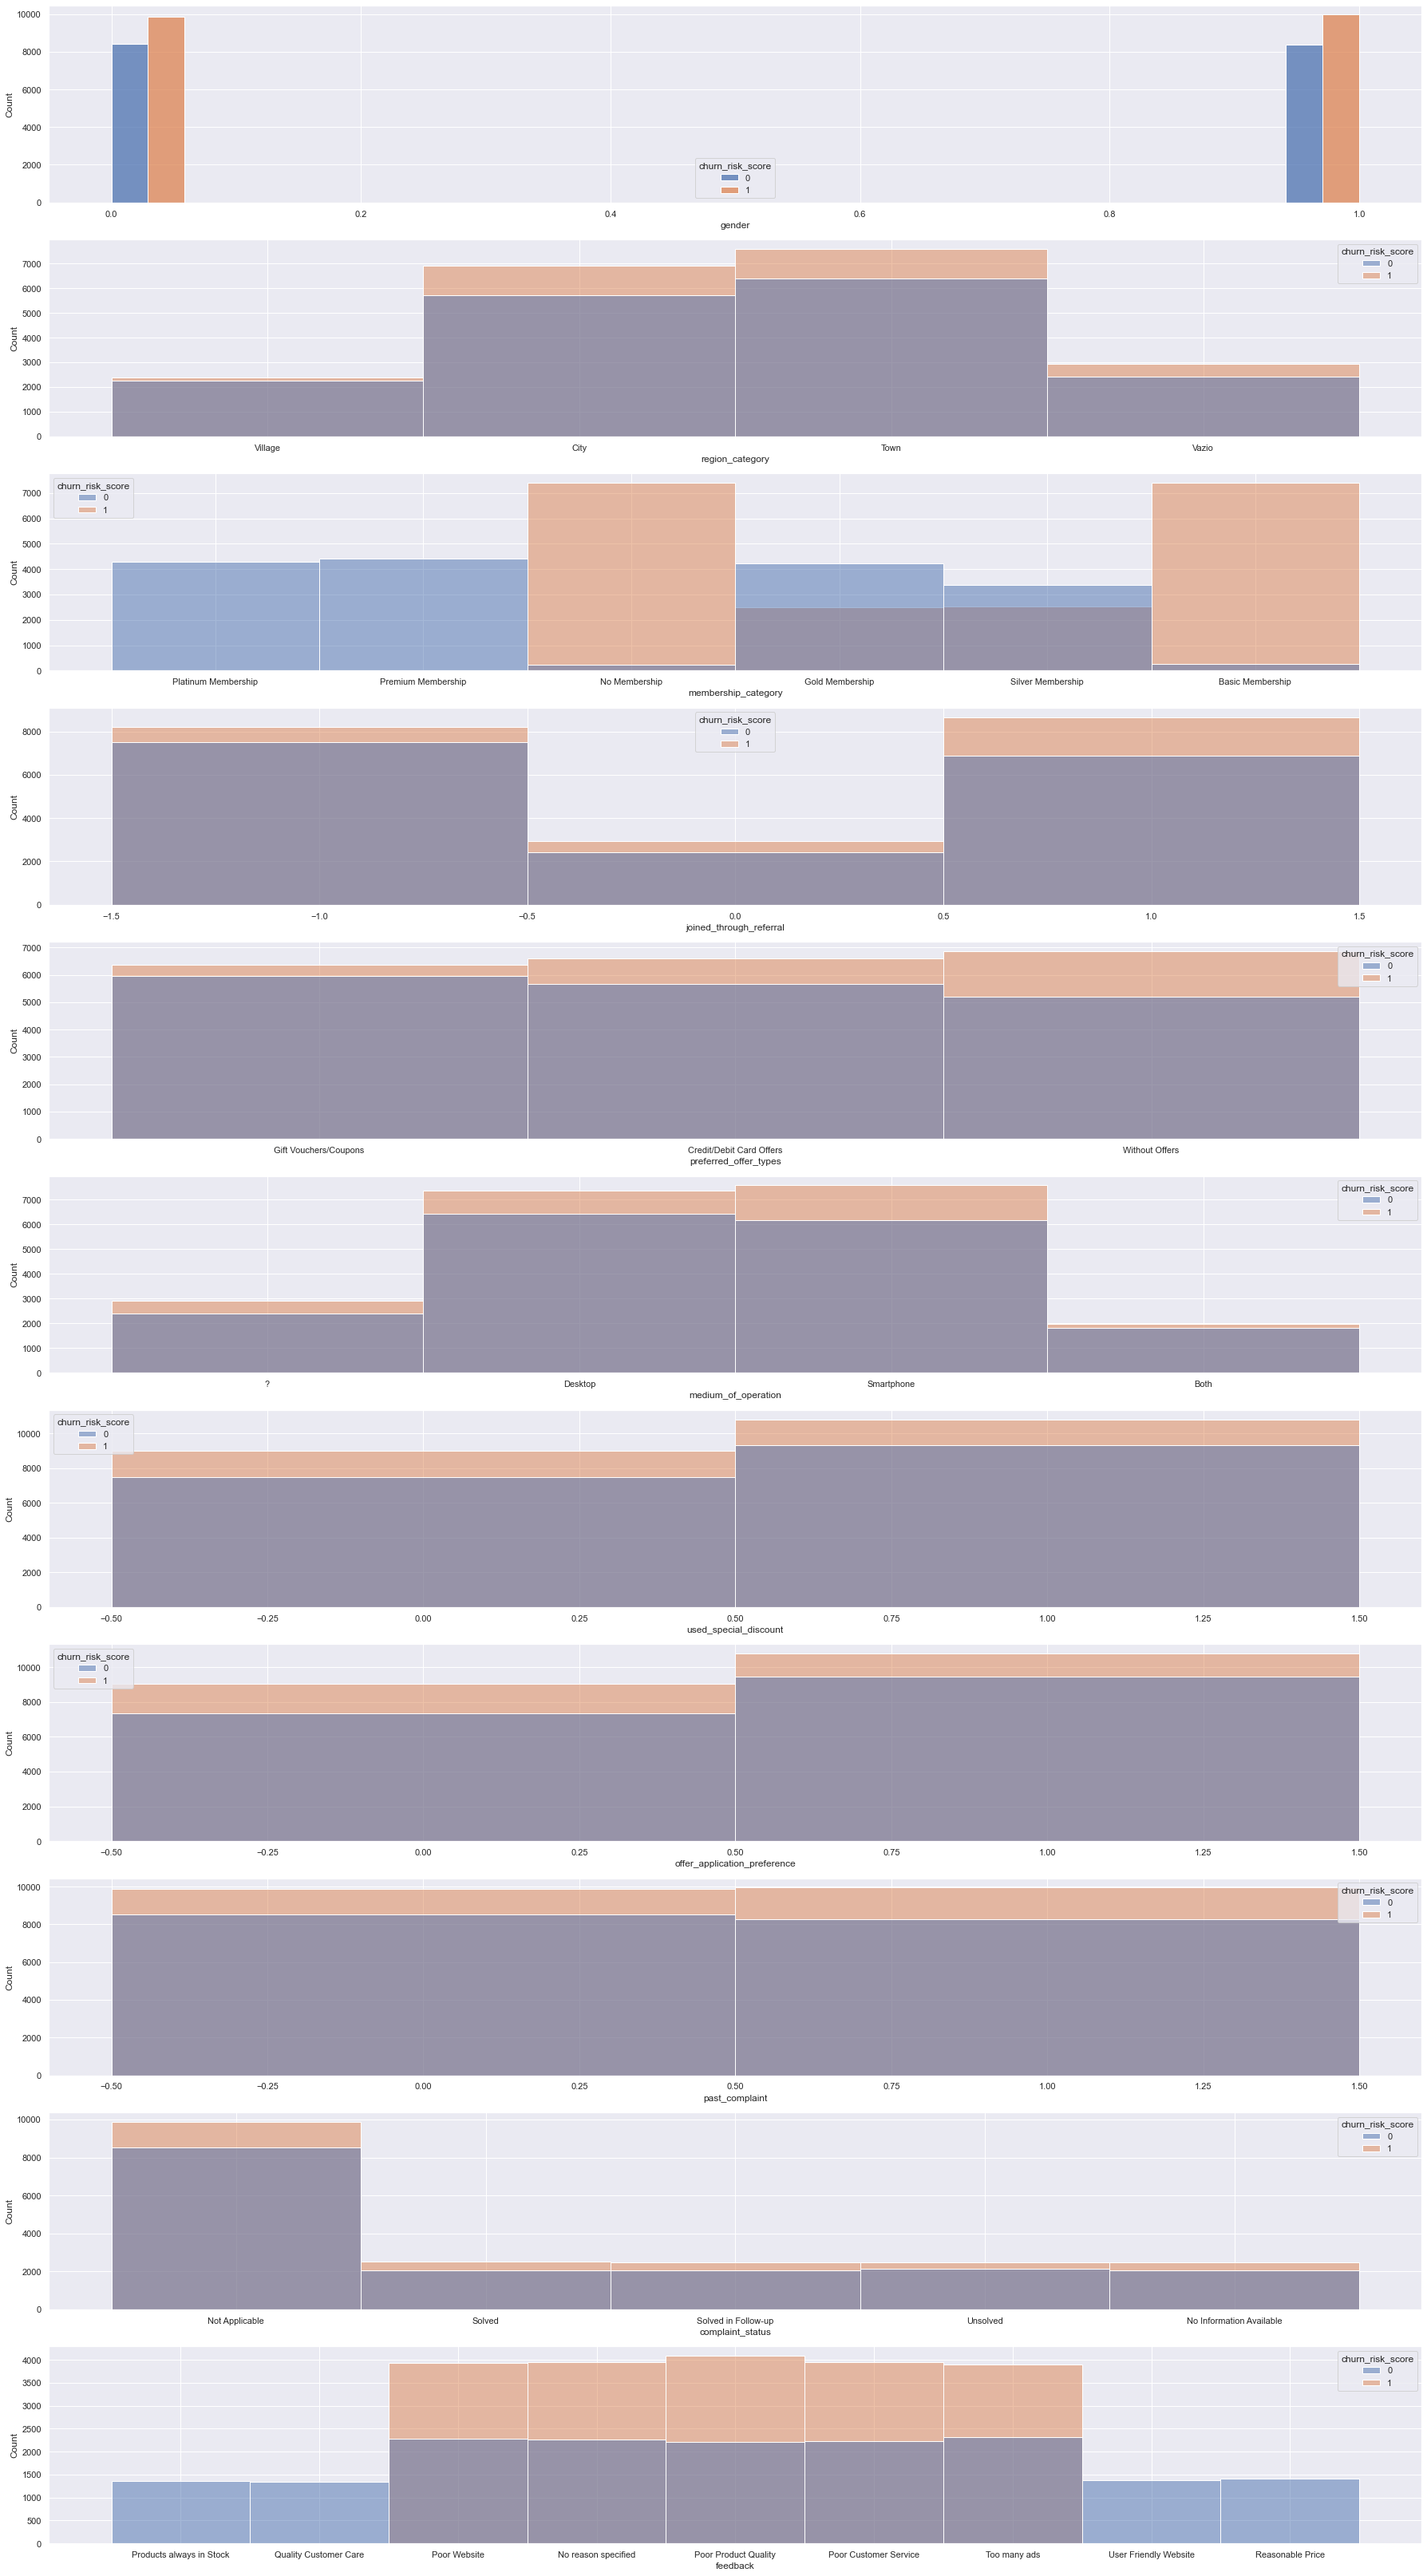

In [727]:
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
df = df_churn

fig, axs = plt.subplots(11, 1, figsize=(25, 45))

sns.histplot(data=df, x="gender",color="red",hue="churn_risk_score",multiple="dodge", ax=axs[0])
sns.histplot(data=df, x="region_category",hue="churn_risk_score", color="teal", discrete=True ,ax=axs[1])
sns.histplot(data=df, x="membership_category", hue="churn_risk_score", color="teal", discrete=True,ax=axs[2])
sns.histplot(data=df, x="joined_through_referral", hue="churn_risk_score", color="teal", discrete=True,ax=axs[3])
sns.histplot(data=df, x="preferred_offer_types", hue="churn_risk_score", color="teal", discrete=True,ax=axs[4])
sns.histplot(data=df, x="medium_of_operation", hue="churn_risk_score", color="teal", discrete=True,ax=axs[5])
sns.histplot(data=df, x="used_special_discount", hue="churn_risk_score", color="teal", discrete=True,ax=axs[6])
sns.histplot(data=df, x="offer_application_preference", hue="churn_risk_score", color="teal", discrete=True,ax=axs[7])
sns.histplot(data=df, x="past_complaint", hue="churn_risk_score", color="teal", discrete=True,ax=axs[8])
sns.histplot(data=df, x="complaint_status", hue="churn_risk_score", color="teal", discrete=True,ax=axs[9])
sns.histplot(data=df, x="feedback", hue="churn_risk_score", color="teal", discrete=True,ax=axs[10])

plt.show()

In [728]:
df_churn = df_churn.fillna(df_churn['points_in_wallet'].mean())

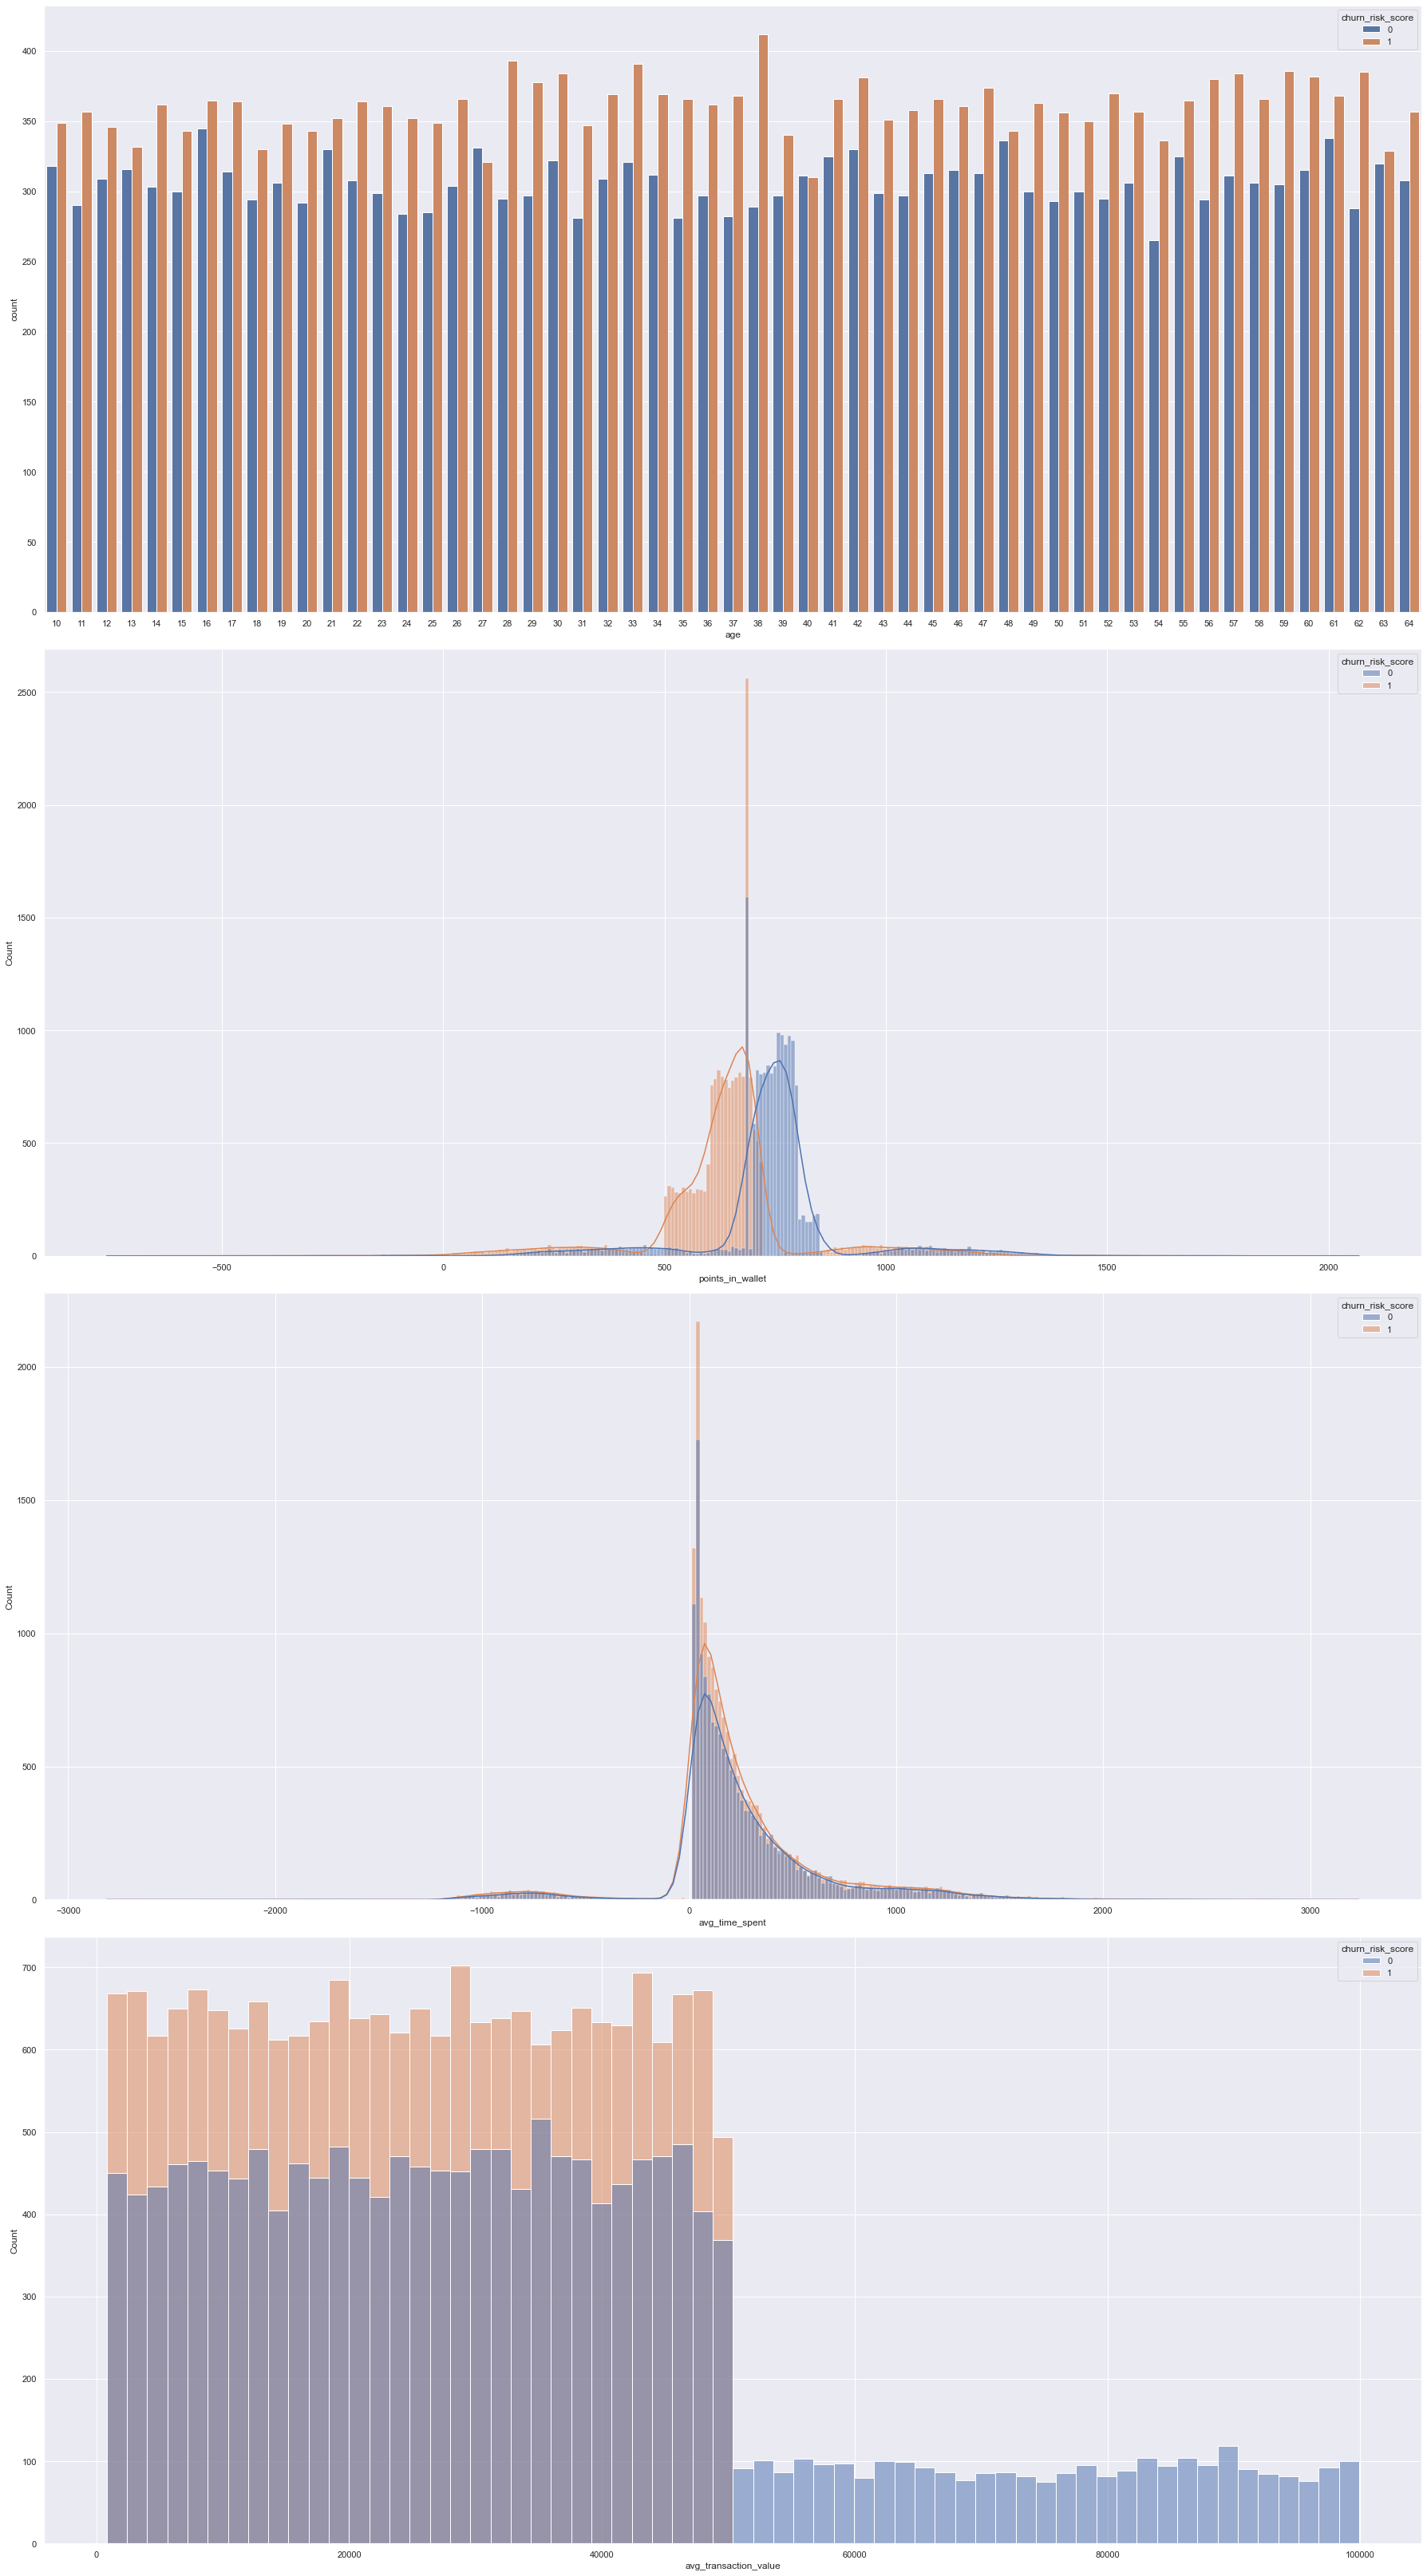

In [729]:
sns.set(style="darkgrid")
df = df_churn

fig, axs = plt.subplots(4, 1, figsize=(25, 45))

sns.countplot(data=df, x="age", hue="churn_risk_score", ax=axs[0])
sns.histplot(data=df, x="points_in_wallet", hue="churn_risk_score",kde=True, discrete=False,ax=axs[1])
sns.histplot(data=df, x="avg_time_spent", hue="churn_risk_score", kde=True, discrete=False,ax=axs[2])
sns.histplot(data=df, x="avg_transaction_value", hue="churn_risk_score", color="teal", discrete=False,ax=axs[3])

plt.show()

<font size="6"><div align="center"><span style="color:blue">Section II - Handling data</span></div></font>

<font size="3"><div align="left"><span style="color:black">In this section II the variables are treated.</span></div></font>


In [730]:
df_churn['feedback']=df_churn['feedback'].map({'Products always in Stock':1,
                             'User Friendly Website':1,'Reasonable Price':1,'Quality Customer Care':1,
                             'Poor Product Quality':0,'Poor Website':0,'No reason specified':0,'Too many ads':0,
                             'Poor Customer Service':0},
                             na_action=None)

df_churn['membership_category']=df_churn['membership_category'].map({'Basic Membership':'Until basic',
                             'No Membership':'Until basic','Silver Membership':'Silve and Gold','Gold Membership':'Silve and Gold',
                             'Premium Membership':'Premium and Platium','Platinum Membership':'Premium and Platium'},
                             na_action=None)

In [731]:
def absolute_maximum_scale(series):
    return series / series.abs().max()

for col in df_churn.columns:
    df_churn['avg_transaction_value'] = absolute_maximum_scale(df_churn['avg_transaction_value'])
    df_churn['points_in_wallet'] = absolute_maximum_scale(df_churn['points_in_wallet'])
    df_churn['age_new'] = absolute_maximum_scale(df_churn['age'])
    df_churn['avg_time_spent'] = absolute_maximum_scale(df_churn['avg_time_spent'])

In [732]:
categorical_cols = ['region_category','membership_category','preferred_offer_types','medium_of_operation','internet_option',
                   'complaint_status','feedback']

for k in categorical_cols:
    if df_churn[k].dtypes == 'object':    
        df_ = df_churn[k].unique()
        p = []
    
        for i in df_:
            for j in df_churn[k]:
                if i == j:
                    p.append(1)
                else:
                    p.append(0)
            df_churn[k + " " + i] = p
            p=[]
    else:
        p = []

In [733]:
df_churn.head()

,Unnamed: 0,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,...,medium_of_operation Smartphone,medium_of_operation Both,internet_option Wi-Fi,internet_option Mobile_Data,internet_option Fiber_Optic,complaint_status Not Applicable,complaint_status Solved,complaint_status Solved in Follow-up,complaint_status Unsolved,complaint_status No Information Available
0,0,18,1,XW0DQ7H,Village,Premium and Platium,2017-08-17,-1,xxxxxxxx,Gift Vouchers/Coupons,...,0,0,1,0,0,1,0,0,0,0
1,1,32,1,5K0N3X1,City,Premium and Platium,2017-08-28,0,CID21329,Gift Vouchers/Coupons,...,0,0,0,1,0,0,1,0,0,0
2,2,44,1,1F2TCL3,Town,Until basic,2016-11-11,1,CID12313,Gift Vouchers/Coupons,...,0,0,1,0,0,0,0,1,0,0
3,3,37,0,VJGJ33N,City,Until basic,2016-10-29,1,CID3793,Gift Vouchers/Coupons,...,0,0,0,1,0,0,0,0,1,0
4,4,31,1,SVZXCWB,City,Until basic,2017-09-12,-1,xxxxxxxx,Credit/Debit Card Offers,...,1,0,0,1,0,0,1,0,0,0


In [734]:
count_nan_in_df = df_churn.isnull().sum()
print (count_nan_in_df)

Unnamed: 0                                        0
age                                               0
gender                                            0
security_no                                       0
region_category                                   0
membership_category                               0
joining_date                                      0
joined_through_referral                           0
referral_id                                       0
preferred_offer_types                             0
medium_of_operation                               0
internet_option                                   0
last_visit_time                                   0
days_since_last_login                             0
avg_time_spent                                    0
avg_transaction_value                             0
avg_frequency_login_days                          0
points_in_wallet                                  0
used_special_discount                             0
offer_applic

<font size="6"><div align="center"><span style="color:blue">Section III - Developing models</span></div></font>

<font size="4"><div align="left"><span style="color:blue">Step I - Remove unwanted columns</span></div></font>

In [735]:
df_churn=df_churn.drop(columns=['Unnamed: 0','avg_frequency_login_days','region_category','security_no',
                                'membership_category','joining_date','referral_id','last_visit_time','days_since_last_login',
                               'preferred_offer_types','medium_of_operation','internet_option','complaint_status',
                               'feedback'])

<font size="4"><div align="left"><span style="color:blue">Step II - Base segmentation</span></div></font>

In [736]:
Y = df_churn[churn_target_col]
X = df_churn.drop(churn_target_col, axis=1)

# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.3)
cvfold = model_selection.StratifiedKFold(n_splits = 10, random_state = 1, shuffle=True)

df_train = xtrain.copy()
df_test = xtest.copy()
df_train['train_set'] = 1
df_test['train_set'] = 0
df_train[churn_target_col] = ytrain
df_test[churn_target_col] = ytest

<font size="3"><div align="left"><span style="color:black">For the models I use the CV (Cross-validadtion). Cross-validation is a technique to assess the generalizability of a model from a data set. This technique is widely used in problems where the modeling objective is prediction.</span></div></font>

<font size="3"><div align="left"><span style="color:black">The central concept of cross-validation techniques is the partitioning of the dataset into mutually exclusive subsets, and later, the use of some of these subsets to estimate the model parameters (training data), with the remaining subsets (validation data) or test) used in model validation.</span></div></font>

<font size="3"><div align="left"><span style="color:black">I Use RFE or RFECV for fit the best variables to maximized the accuracy  </span></div></font>

<font size="4"><div align="left"><span style="color:blue">Step III - Logistic Regression</span></div></font>

<font size="3"><div align="left"><span style="color:black">To train this model I chose to do a loop to find the best numbers of variable and the ones who maximize the accuracy. It is possible select other score reference to chose best model, depends what is the business wants. </span></div></font>

<font size="3"><div align="left"><span style="color:black">Linear regression is used to predict the continuous dependent variable using a given set of independent variables. Logistic Regression is used to predict the categorical dependent variable using a given set of independent variables. For that reason in this example was chosen de logistic regression</span></div></font>


In [737]:
def nums(first_number, last_number, step=1):
    return range(first_number, last_number+1, step)

vect_lr=[]
vect_nm=[]

df_lr = pandas.DataFrame(data=[])
pp = len(df_churn.columns)

for p in nums(1,pp):
    rfe = RFE(estimator=lm.LogisticRegression(), n_features_to_select=p)
    model_lr = lm.LogisticRegression()

    model_lr = pipeline.Pipeline([('Feature Selection', rfe), ('Model', model_lr)])

    model_lr.fit(xtrain, ytrain)

    df_train['decision_lr'] = model_lr.predict(xtrain)
    df_test['decision_lr']  = model_lr.predict(xtest)
    df_train['probability_lr'] = model_lr.predict_proba(xtrain)[:,1]
    df_test['probability_lr']  = model_lr.predict_proba(xtest)[:,1]

    df_churn = pandas.concat((df_train, df_test), axis=0)
    idxlr = df_churn['train_set'] == 0
    
    vect_lr.append(metrics.accuracy_score(df_churn[idxlr][churn_target_col],
                                          df_churn[idxlr]['decision_lr']))
    vect_nm.append(p)

<font size="3"><div align="left"><span style="color:black">The best choice is a model how has 4 variables the accuracy is 0.8710205566672731, but it is worth noting that after 4 variables the accuracy is very close. It's possibel to use, for example, 5 or 6 variables to fit the model... See below. The choice is based on based to not cause overfitting when test de accuracy</span></div></font>

In [738]:
def plot_operation_variables(Variables):
    sns.lineplot(vect_nm,vect_lr)
    plt.plot([Variables, Variables],[0, plt.axis()[1]], '--k', lw=2, label = 'Selection')
    print('\t'+'Accuracy' + '\t'+ str(vect_lr[Variables-1]))
    plt.title('Number of variables by Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Number of variables')
    plt.ylim((0.75,0.90))
    plt.grid()
    plt.legend()
    plt.show()

interact(plot_operation_variables, Variables=(1,40,1))

interactive(children=(IntSlider(value=20, description='Variables', max=40, min=1), Output()), _dom_classes=('w…

<function __main__.plot_operation_variables(Variables)>

<font size="3"><div align="left"><span style="color:black">After to find the ideal number of features, the model is trainned </span></div></font>

In [739]:
rfe = RFE(estimator=lm.LogisticRegression(), n_features_to_select=4)
model_lr = lm.LogisticRegression()

model_lr = pipeline.Pipeline([('Feature Selection', rfe), ('Model', model_lr)])

model_lr.fit(xtrain, ytrain)

df_train['decision_lr'] = model_lr.predict(xtrain)
df_test['decision_lr']  = model_lr.predict(xtest)
df_train['probability_lr'] = model_lr.predict_proba(xtrain)[:,1]
df_test['probability_lr']  = model_lr.predict_proba(xtest)[:,1]

df_churn = pandas.concat((df_train, df_test), axis=0)
idxlr = df_churn['train_set'] == 0
    
cm_lr = metrics.confusion_matrix(df_churn[idxlr][churn_target_col],
                                  df_churn[idxlr]['decision_lr'])

<font size="3"><div align="left"><span style="color:black">This grafic shows the features selected by the model. </span></div></font>

In [740]:
def plot_coefs(model, class_label, target_label_map):
    fig = plt.figure(figsize=(15,4))
    
    iclass = 0
    if class_label != '':
        idx  = target_label_map.target_label==class_label
        iclass = target_label_map.loc[idx, 'target'].values[0]
    
    if len(model.coef_.shape) == 2:
        coefs = model.coef_[iclass]
    else:
        coefs = model.coef_
        
    coef_names = xtrain.columns

    idx = np.argsort(coefs)

    plt.bar(np.arange(coefs.shape[0]), coefs[idx])
    plt.xticks(np.arange(coefs.shape[0]), coef_names[idx], rotation='90')
    plt.title('Coeficientes do modelo ' + model.__class__.__name__ + ' ' + class_label)
    plt.grid()
    plt.xlim((-0.5, coefs.shape[0]-0.5))
    plt.show()
    
    
interact(plot_coefs, model = fixed(model_lr.steps[1][1]), 
         class_label = fixed(''),
         target_label_map = fixed(churn_label_map))

interactive(children=(Output(),), _dom_classes=('widget-interact',))

<function __main__.plot_coefs(model, class_label, target_label_map)>

<font size="4"><div align="left"><span style="color:blue">Step III - Decision Tree</span></div></font>

<font size="3"><div align="left"><span style="color:black">To train this model I chose to do a loop to find the best number of variables and the ones who maximize the accuracy. It is possible select other score reference to chose best model, depends what is the business wants. </span></div></font>

In [741]:
count_row = xtrain.shape[0]

vect_dt=[]
vect_nn=[]

df_dt = pandas.DataFrame(data=[])

for p in nums(1,20):
    rfecv = RFECV(estimator=tree.DecisionTreeClassifier(criterion="entropy", 
                                                splitter='best', max_depth = p),cv=cvfold,n_jobs=-1)
    model_ = tree.DecisionTreeClassifier(criterion="entropy", 
                                                splitter='best', max_depth = p)
    
    model_dt = pipeline.Pipeline([('Feature Selection', rfecv), ('Model', model_)])  

    model_dt.fit(xtrain, ytrain)

    df_train['decision_dt'] = model_dt.predict(xtrain)
    df_test['decision_dt']  = model_dt.predict(xtest)
    df_train['probability_dt'] = model_dt.predict_proba(xtrain)[:,1]
    df_test['probability_dt']  = model_dt.predict_proba(xtest)[:,1]

    df_churn = pandas.concat((df_train, df_test), axis=0)
    idxdt = df_churn['train_set'] == 0
    
    vect_dt.append(metrics.accuracy_score(df_churn[idxdt][churn_target_col],
                                          df_churn[idxdt]['decision_dt']))
    vect_nn.append(p)

<font size="3"><div align="left"><span style="color:black">The best choice is the model who has 5 max_depth, the accuracy is 0.930325632162998, but it is worth noting that choose any model that has more than 5 variables the accuracy value is close. It's possibel to use, for example, 6 or 7 variables to fit the model... See below. The choice took into account the slope of the curve, taking care not to cause overfitting. </span></div></font>

In [742]:
def plot_operation_percentual(perc_samples_leaf):
    sns.lineplot(vect_nn,vect_dt)
    plt.plot([perc_samples_leaf, perc_samples_leaf],[0, plt.axis()[3]], '--k', lw=2, label = 'Selection')
    # PRINT CLASSIFICATION REPORT
    print('\t'+'Accuracy' + '\t'+ str(vect_dt[int((perc_samples_leaf)-1)]))
    plt.title('% Min Samples Leaf by Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('% Min Samples Leaf')
    plt.xlim((-0.01,21))
    plt.ylim((0.84,1))
    plt.grid()
    plt.legend()
    plt.show()

interact(plot_operation_percentual,perc_samples_leaf=(1,20,1))

interactive(children=(IntSlider(value=10, description='perc_samples_leaf', max=20, min=1), Output()), _dom_cla…

<function __main__.plot_operation_percentual(perc_samples_leaf)>

<font size="3"><div align="left"><span style="color:black">After to find the ideal number of features, the model is trainned </span></div></font>

In [743]:
count_row = xtrain.shape[0]

rfecv = RFECV(estimator=tree.DecisionTreeClassifier(criterion="entropy", 
                                                splitter='best', max_depth = 5),cv=cvfold,n_jobs=-1)

model_ = tree.DecisionTreeClassifier(criterion="entropy", 
                                                splitter='best', max_depth = 5)

model_dt = pipeline.Pipeline([('Feature Selection', rfecv), ('Model', model_)])

model_dt.fit(xtrain, ytrain)

df_train['decision_dt'] = model_dt.predict(xtrain)
df_test['decision_dt']  = model_dt.predict(xtest)
df_train['probability_dt'] = model_dt.predict_proba(xtrain)[:,1]
df_test['probability_dt']  = model_dt.predict_proba(xtest)[:,1]

df_churn = pandas.concat((df_train, df_test), axis=0)
idxdt = df_churn['train_set'] == 0

cm_dt = metrics.confusion_matrix(df_churn[idxdt][churn_target_col],
                                  df_churn[idxdt]['decision_dt'])

<font size="3"><div align="left"><span style="color:black">This grafic shows the features selected by the model.  </span></div></font>

<font size="3"><div align="left"><span style="color:black">Interesting to observe that the model chose two variables gender and age for fit the data, the insight we can get is the women has more rate of churn risk (they are classificatad in the model by number '1') and have a specific group of mens who is 19 - 21 years old.</span></div></font>

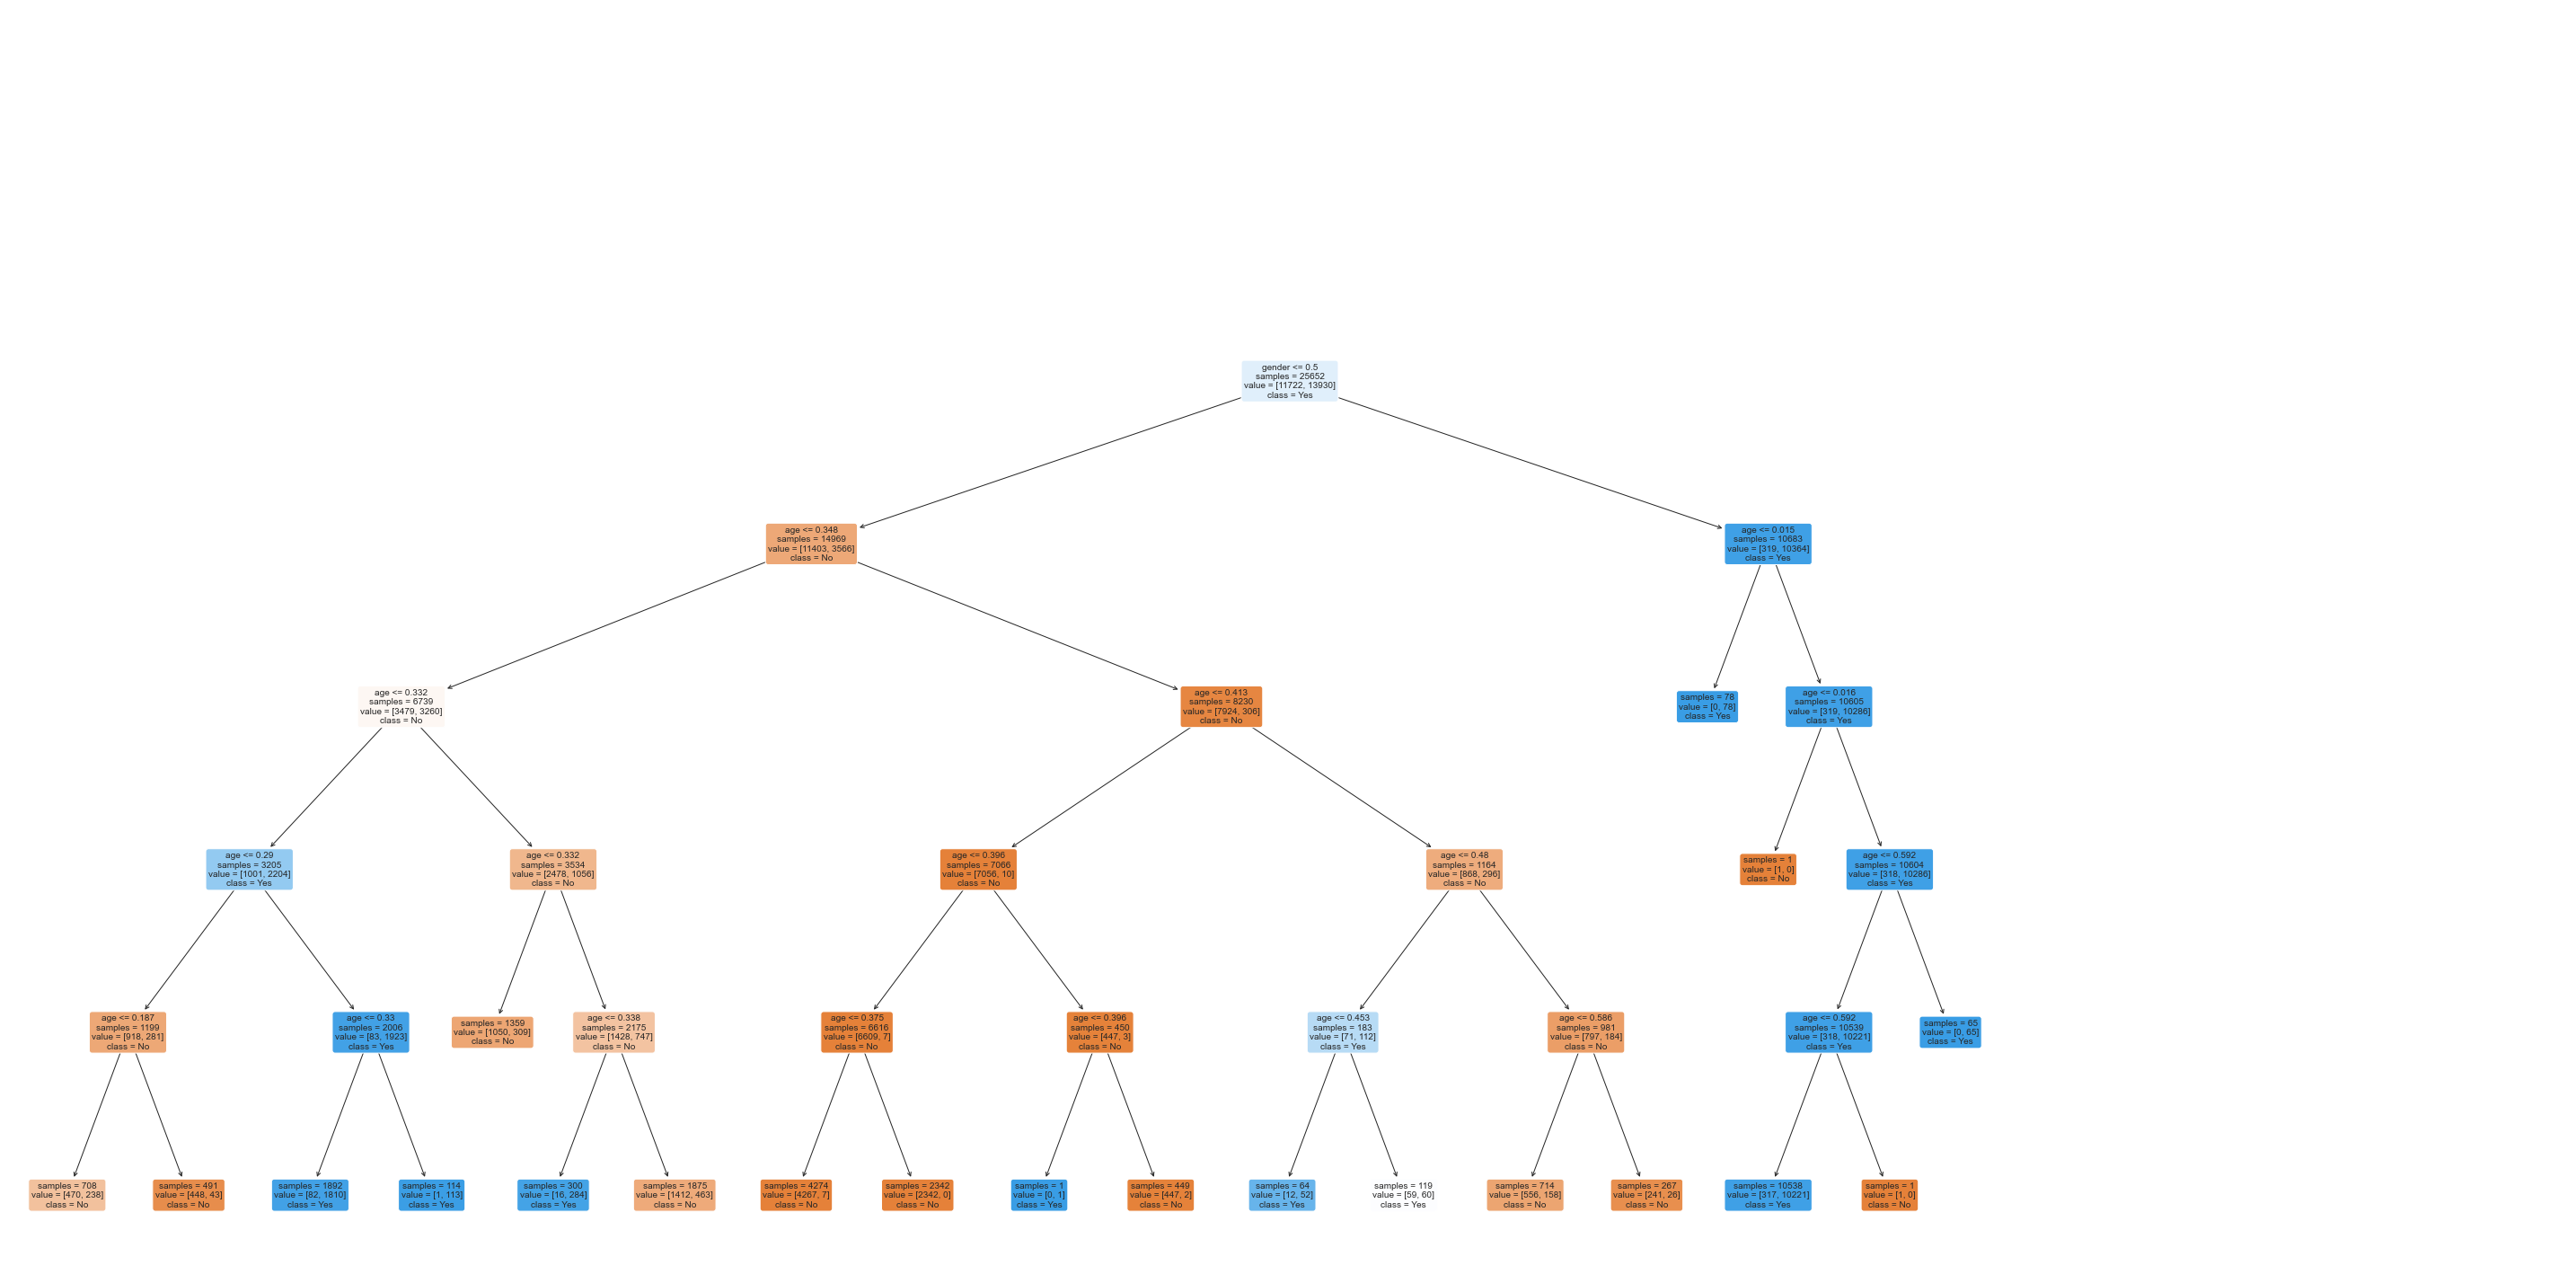

In [744]:
dt_feature_names = list(df_churn.columns)

nhh = plt.figure(figsize=(40,20))
tree.plot_tree(model_dt['Model'],feature_names=dt_feature_names,fontsize=10
#               , filled=True, rounded=True)
               ,class_names=['No','Yes'], filled=True, rounded=True, impurity=False)
plt.show()


#nhh.savefig(r"C:\Users\costa\Downloads\decistion_tree.png")

<font size="4"><div align="left"><span style="color:blue">Step III - SVM</span></div></font>

<font size="3"><div align="left"><span style="color:black">The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points. To train this model I chose to do a loop to find the best parameters for the kernel. </span></div></font>

In [745]:
model_params = {
     'svm': {
         'kernel': ['linear', 'rbf','poly', 'sigmoid']
     }
}

vect_svm=[]
vect_nsv=[]

df_dts = pandas.DataFrame(data=[])
ff = int(len(model_params['svm']['kernel']))

for p in nums(0,ff-1):
    
    model = svm.SVC(kernel=model_params['svm']['kernel'][p], probability=True)
    model_svm = pipeline.Pipeline([('Model', model)])
    model_svm.fit(xtrain, ytrain)
    
    df_train['decision_svm'] = model_svm.predict(xtrain)
    df_test['decision_svm']  = model_svm.predict(xtest)
    df_train['probability_svm'] = model_svm.predict_proba(xtrain)[:,1]
    df_test['probability_svm']  = model_svm.predict_proba(xtest)[:,1]

    df_churn = pandas.concat((df_train, df_test), axis=0)
    idxsvm = df_churn['train_set'] == 0
    
    vect_svm.append(metrics.accuracy_score(df_churn[idxsvm][churn_target_col],
                                          df_churn[idxsvm]['decision_svm']))
    vect_nsv.append(model_params['svm']['kernel'][p])

<font size="3"><div align="left"><span style="color:black">The best choice is a model how has kernel = 'linear', the accuracy is 0.852829, but it is worth noting that is possible to select 'rbf'... See below.</span></div></font>

No handles with labels found to put in legend.


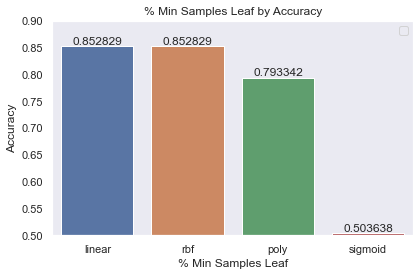

In [762]:
sns.barplot(vect_nsv,vect_svm)
plt.title('% Min Samples Leaf by Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('% Min Samples Leaf')
plt.ylim((0.50,0.90))
plt.grid()
plt.legend()
ax = sns.barplot(vect_nsv,vect_svm, dodge=True)
ax.bar_label(ax.containers[0])

plt.show()

<font size="3"><div align="left"><span style="color:black">After to chose the best kernel, the model is trainned </span></div></font>

In [ ]:
model = svm.SVC(kernel='linear', probability=True)

model_svm = pipeline.Pipeline([('Model', model)])

model_svm.fit(xtrain, ytrain)

df_train['decision_svm'] = model_svm.predict(xtrain)
df_test['decision_svm']  = model_svm.predict(xtest)
df_train['probability_svm'] = model_svm.predict_proba(xtrain)[:,1]
df_test['probability_svm']  = model_svm.predict_proba(xtest)[:,1]

df_churn = pandas.concat((df_train, df_test), axis=0)
idxsvm = df_churn['train_set'] == 0

cm_svm = metrics.confusion_matrix(df_churn[idxsvm][churn_target_col],
                                  df_churn[idxsvm]['decision_svm'])

<font size="6"><div align="center"><span style="color:blue">Section IV - Comparing Classification Models - Validation Train</span></div></font>

<font size="3"><div align="left"><span style="color:black">It is a metric aimed at classification models and aims to calculate the number of false positives and false negatives; and true positive and true negative, as well as providing you with accuracy and sensitivity.</span></div></font>

<font size="3"><div align="left"><span style="color:black">You can see below the matrix of confusion of the models, in general, all models are good and have a low errors </span></div></font>

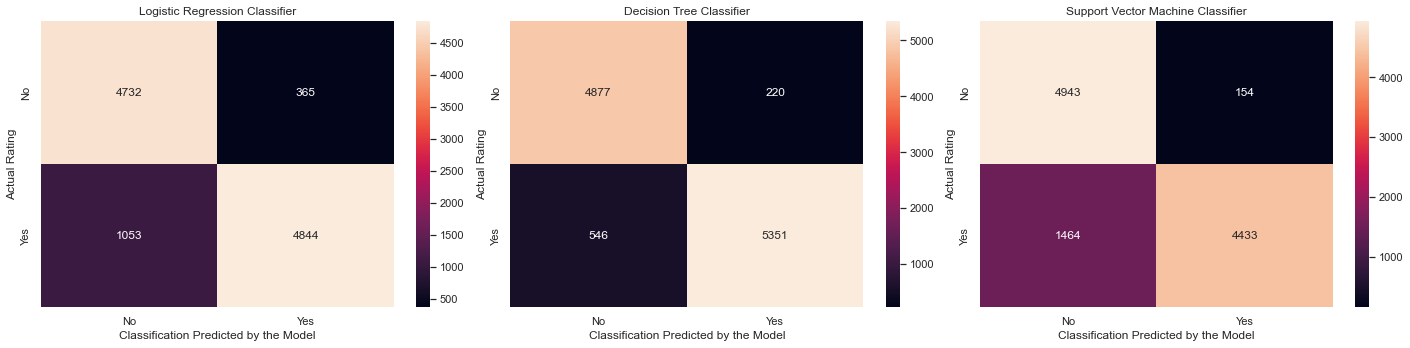

In [758]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

sns.heatmap(cm_lr, fmt='', annot=True,ax=axs[0])
sns.heatmap(cm_dt, fmt='', annot=True,ax=axs[1])
sns.heatmap(cm_svm, fmt='', annot=True,ax=axs[2])

axs[0].set_title('Logistic Regression Classifier')
axs[1].set_title('Decision Tree Classifier')
axs[2].set_title('Support Vector Machine Classifier')

for i in axs:
    i.set_xlabel('Classification Predicted by the Model')
    i.set_ylabel('Actual Rating')

    i.set_xticklabels({"No":0,"Yes":1})
    i.set_yticklabels({"No":0,"Yes":1})

plt.show()

<font size="3"><div align="left"><span style="color:black">You can see below the comparation of the scores accuracy, F1, precision and recall. The best model in accuracy, F1, Recall is Decision tree model, permormaing up to 90%. The performance of the others model are similar, nevertheless Logistic Regression is better than SVM, although in precision the SVM is the best.</span></div></font>

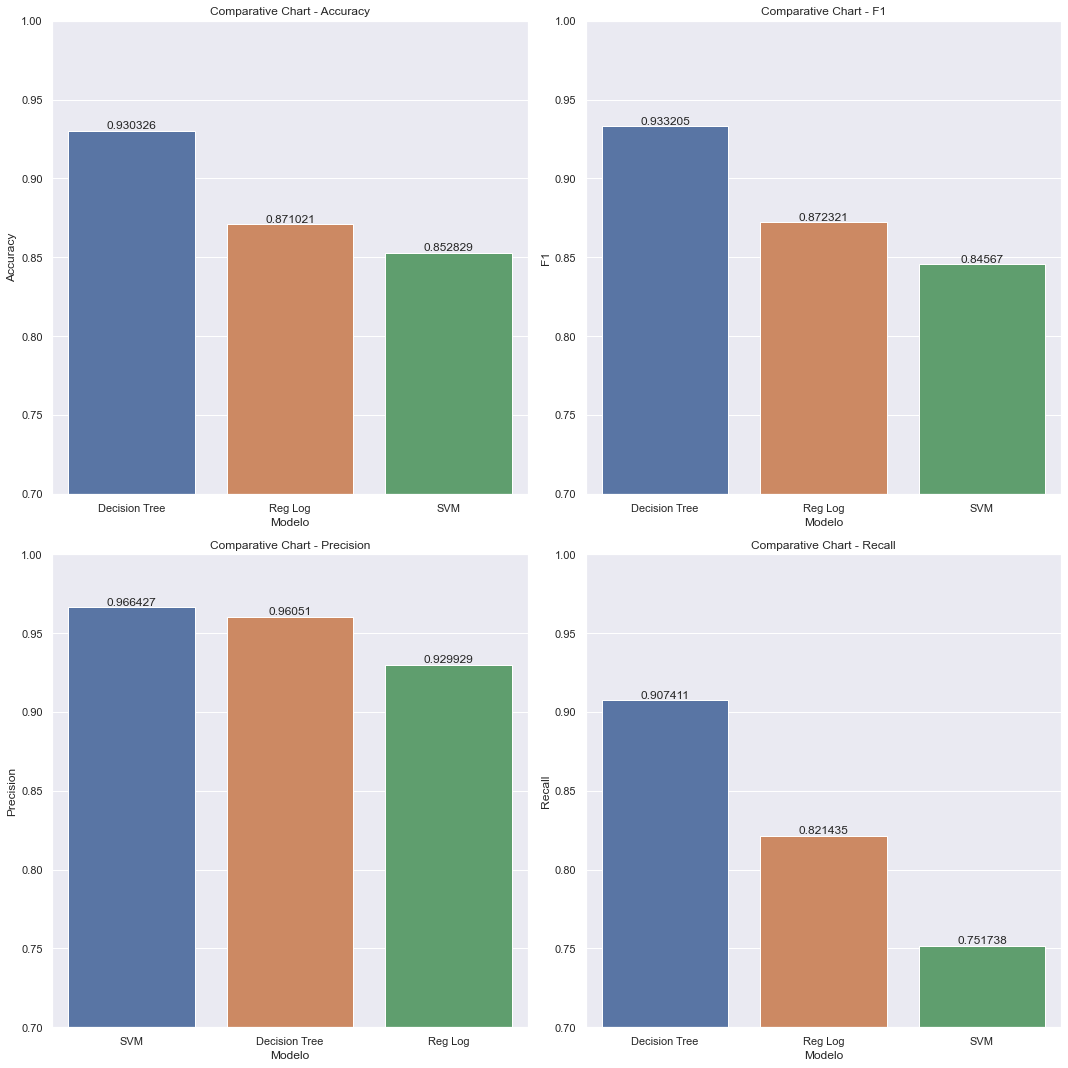

In [759]:
vetor_x = ['Reg Log','Decision Tree', 'SVM']
vetor_color = ['green', 'blue','yellow']

vetor_y = [ metrics.accuracy_score(df_churn[idxlr][churn_target_col],
                                  df_churn[idxlr]['decision_lr']),
            metrics.accuracy_score(df_churn[idxdt][churn_target_col],
                                  df_churn[idxdt]['decision_dt']),
            metrics.accuracy_score(df_churn[idxsvm][churn_target_col],
                                  df_churn[idxsvm]['decision_svm'])]

vetor_z = [ metrics.f1_score(df_churn[idxlr][churn_target_col],
                                  df_churn[idxlr]['decision_lr']),
            metrics.f1_score(df_churn[idxdt][churn_target_col],
                                  df_churn[idxdt]['decision_dt']),
            metrics.f1_score(df_churn[idxsvm][churn_target_col],
                                  df_churn[idxsvm]['decision_svm'])]

vetor_w = [ metrics.precision_score(df_churn[idxlr][churn_target_col],
                                  df_churn[idxlr]['decision_lr']),
            metrics.precision_score(df_churn[idxdt][churn_target_col],
                                  df_churn[idxdt]['decision_dt']),
            metrics.precision_score(df_churn[idxsvm][churn_target_col],
                                  df_churn[idxsvm]['decision_svm'])]

vetor_k = [ metrics.recall_score(df_churn[idxlr][churn_target_col],
                                  df_churn[idxlr]['decision_lr']),
            metrics.recall_score(df_churn[idxdt][churn_target_col],
                                  df_churn[idxdt]['decision_dt']),
            metrics.recall_score(df_churn[idxsvm][churn_target_col],
                                  df_churn[idxsvm]['decision_svm'])]

vetor_n = [ metrics.roc_curve(df_churn[idxlr][churn_target_col],
                                  df_churn[idxlr]['probability_lr']),
            metrics.roc_curve(df_churn[idxdt][churn_target_col],
                                  df_churn[idxdt]['probability_dt']),
            metrics.roc_curve(df_churn[idxsvm][churn_target_col],
                                  df_churn[idxsvm]['probability_svm'])]

df_f = pandas.DataFrame({'Modelo':vetor_x,'Accuracy':vetor_y,'F1':vetor_z, 'Precision':vetor_w, 'Recall':vetor_k, 'ROC':vetor_n})

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

sns.barplot(df_f['Modelo'],df_f['Accuracy'],ax=axs[0,0],order=df_f.sort_values('Accuracy', ascending = False).Modelo)
sns.barplot(df_f['Modelo'],df_f['F1'],ax=axs[0,1],order=df_f.sort_values('F1',ascending = False).Modelo)
sns.barplot(df_f['Modelo'],df_f['Precision'],ax=axs[1,0],order=df_f.sort_values('Precision',ascending = False).Modelo)
sns.barplot(df_f['Modelo'],df_f['Recall'],ax=axs[1,1],order=df_f.sort_values('Recall',ascending = False).Modelo)


axs[0,0].set_title('Comparative Chart - Accuracy')
axs[0,1].set_title('Comparative Chart - F1')
axs[1,0].set_title('Comparative Chart - Precision')
axs[1,1].set_title('Comparative Chart - Recall')

axs[0,0].set_ylim([0.70, 1])
axs[0,1].set_ylim([0.70, 1])
axs[1,0].set_ylim([0.70, 1])
axs[1,1].set_ylim([0.70, 1])

ax = sns.barplot(df_f['Modelo'],df_f['Accuracy'],ax=axs[0,0],order=df_f.sort_values('Accuracy', ascending = False).Modelo)
ax.bar_label(ax.containers[0])

ax = sns.barplot(df_f['Modelo'],df_f['F1'],ax=axs[0,1],order=df_f.sort_values('F1',ascending = False).Modelo)
ax.bar_label(ax.containers[0])

ax = sns.barplot(df_f['Modelo'],df_f['Precision'],ax=axs[1,0],order=df_f.sort_values('Precision',ascending = False).Modelo)
ax.bar_label(ax.containers[0])

ax = sns.barplot(df_f['Modelo'],df_f['Recall'],ax=axs[1,1],order=df_f.sort_values('Recall',ascending = False).Modelo)
ax.bar_label(ax.containers[0])

plt.show()

<font size="3"><div align="left"><span style="color:black">The ROC curve shows how well the model can distinguish between two things. These two things can be 0 or 1, or positive and negative. The best models can accurately distinguish the binomial.</span></div></font>

<font size="3"><div align="left"><span style="color:black">The model who has the best performance in the ROC curve is Deciosion Tree </span></div></font>

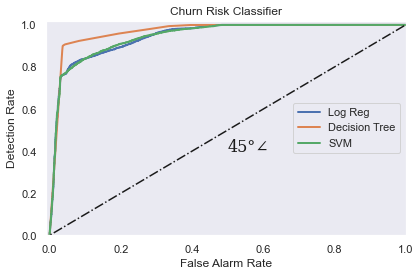

In [760]:
font = {'family': 'serif',
        'color':  'k',
        'weight': 'normal',
        'size': 16
        }

fpr_lr, tpr_lr, thr_lr = metrics.roc_curve(df_churn[idxlr][churn_target_col],
                                  df_churn[idxlr]['probability_lr'])
fpr_dt, tpr_dt, thr_dt = metrics.roc_curve(df_churn[idxdt][churn_target_col],
                                  df_churn[idxdt]['probability_dt'])
fpr_svm, tpr_svm, thr_svm = metrics.roc_curve(df_churn[idxsvm][churn_target_col],
                                  df_churn[idxsvm]['probability_svm'])

plt.plot(fpr_lr, tpr_lr, '-', lw=2, label='Log Reg')
plt.plot(fpr_dt, tpr_dt, '-', lw=2, label='Decision Tree')
plt.plot(fpr_svm, tpr_svm, '-', lw=2, label='SVM')
plt.plot([-.2,1.2], [-.2,1.2], linestyle='-.', color='k')
plt.text(0.5, 0.4, r'45°∠', fontdict=font)

plt.legend(loc='right')
plt.title('Churn Risk Classifier')
plt.grid()
plt.xlabel('False Alarm Rate')
plt.ylabel('Detection Rate')
plt.xlim((-0.01, 1))
plt.ylim((0.0, 1.02))
plt.show()

<font size="6"><div align="center"><span style="color:blue">Section V - Comparing Classification Models - Validation Test</span></div></font>

<font size="3"><div align="left"><span style="color:black">You can see below the matrix of confusion of the models, in general, all models are good and have a low errors in the validation test </span></div></font>

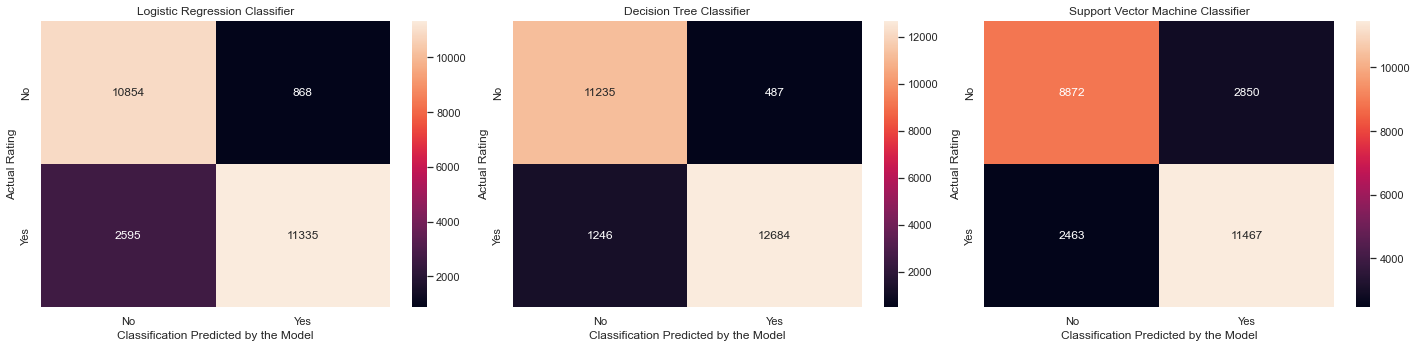

In [751]:
idxtest = df_churn['train_set'] == 1

cm_lr_test = metrics.confusion_matrix(df_churn[idxtest][churn_target_col],
                                      df_churn[idxtest]['decision_lr'])

cm_dt_test = metrics.confusion_matrix(df_churn[idxtest][churn_target_col],
                                  df_churn[idxtest]['decision_dt'])

cm_svm_test = metrics.confusion_matrix(df_churn[idxtest][churn_target_col],
                                  df_churn[idxtest]['decision_svm'])

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

sns.heatmap(cm_lr_test, fmt='', annot=True,ax=axs[0])
sns.heatmap(cm_dt_test, fmt='', annot=True,ax=axs[1])
sns.heatmap(cm_svm_test, fmt='', annot=True,ax=axs[2])

axs[0].set_title('Logistic Regression Classifier')
axs[1].set_title('Decision Tree Classifier')
axs[2].set_title('Support Vector Machine Classifier')

for i in axs:
    i.set_xlabel('Classification Predicted by the Model')
    i.set_ylabel('Actual Rating')

    i.set_xticklabels({"No":0,"Yes":1})
    i.set_yticklabels({"No":0,"Yes":1})

plt.show()

<font size="3"><div align="left"><span style="color:black">You can see below the comparation of the scores accuracy, F1, precision and recall. The best model in all criteria is Decision tree model, permormaing up to 90%. Interesting to see that SVM performed worse in test validation than in train validation
</span></div></font>

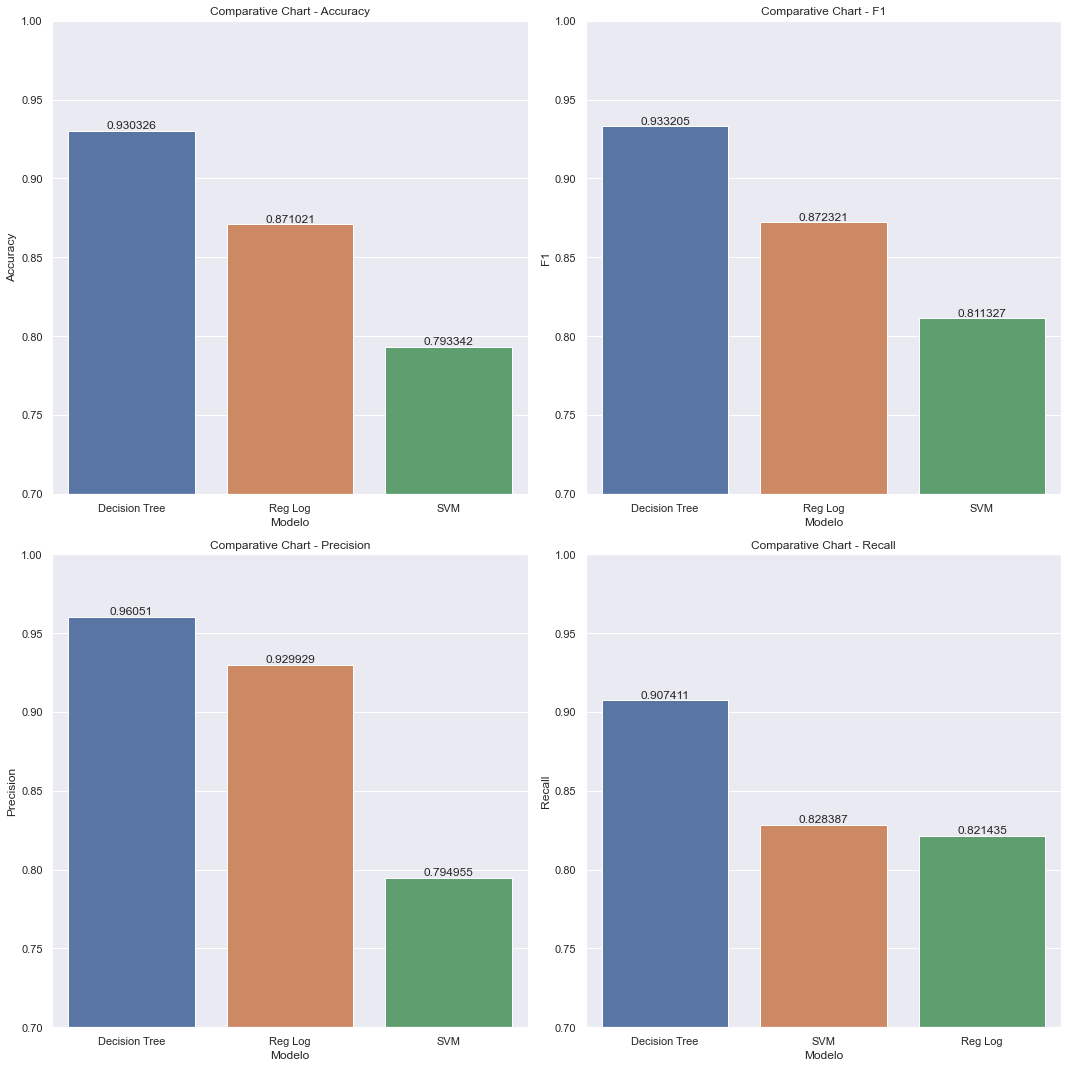

In [752]:
vetor_x = ['Reg Log','Decision Tree', 'SVM']
vetor_color = ['green', 'blue','yellow']

vetor_yf = [ metrics.accuracy_score(df_churn[idxtest][churn_target_col],
                                  df_churn[idxtest]['decision_lr']),
            metrics.accuracy_score(df_churn[idxtest][churn_target_col],
                                  df_churn[idxtest]['decision_dt']),
            metrics.accuracy_score(df_churn[idxtest][churn_target_col],
                                  df_churn[idxtest]['decision_svm'])]

vetor_zf = [ metrics.f1_score(df_churn[idxtest][churn_target_col],
                                  df_churn[idxtest]['decision_lr']),
            metrics.f1_score(df_churn[idxtest][churn_target_col],
                                  df_churn[idxtest]['decision_dt']),
            metrics.f1_score(df_churn[idxtest][churn_target_col],
                                  df_churn[idxtest]['decision_svm'])]

vetor_wf = [ metrics.precision_score(df_churn[idxtest][churn_target_col],
                                  df_churn[idxtest]['decision_lr']),
            metrics.precision_score(df_churn[idxtest][churn_target_col],
                                  df_churn[idxtest]['decision_dt']),
            metrics.precision_score(df_churn[idxtest][churn_target_col],
                                  df_churn[idxtest]['decision_svm'])]

vetor_kf = [ metrics.recall_score(df_churn[idxtest][churn_target_col],
                                  df_churn[idxtest]['decision_lr']),
            metrics.recall_score(df_churn[idxtest][churn_target_col],
                                  df_churn[idxtest]['decision_dt']),
            metrics.recall_score(df_churn[idxtest][churn_target_col],
                                  df_churn[idxtest]['decision_svm'])]

vetor_nf = [ metrics.roc_curve(df_churn[idxtest][churn_target_col],
                                  df_churn[idxtest]['probability_lr']),
            metrics.roc_curve(df_churn[idxtest][churn_target_col],
                                  df_churn[idxtest]['probability_dt']),
            metrics.roc_curve(df_churn[idxtest][churn_target_col],
                                  df_churn[idxtest]['probability_svm'])]

df_f = pandas.DataFrame({'Modelo':vetor_x,'Accuracy':vetor_y,'F1':vetor_z, 'Precision':vetor_w, 'Recall':vetor_k, 'ROC':vetor_n})

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

sns.barplot(df_f['Modelo'],df_f['Accuracy'],ax=axs[0,0],order=df_f.sort_values('Accuracy', ascending = False).Modelo)
sns.barplot(df_f['Modelo'],df_f['F1'],ax=axs[0,1],order=df_f.sort_values('F1',ascending = False).Modelo)
sns.barplot(df_f['Modelo'],df_f['Precision'],ax=axs[1,0],order=df_f.sort_values('Precision',ascending = False).Modelo)
sns.barplot(df_f['Modelo'],df_f['Recall'],ax=axs[1,1],order=df_f.sort_values('Recall',ascending = False).Modelo)


axs[0,0].set_title('Comparative Chart - Accuracy')
axs[0,1].set_title('Comparative Chart - F1')
axs[1,0].set_title('Comparative Chart - Precision')
axs[1,1].set_title('Comparative Chart - Recall')

axs[0,0].set_ylim([0.70, 1])
axs[0,1].set_ylim([0.70, 1])
axs[1,0].set_ylim([0.70, 1])
axs[1,1].set_ylim([0.70, 1])




ax = sns.barplot(df_f['Modelo'],df_f['Accuracy'],ax=axs[0,0],order=df_f.sort_values('Accuracy', ascending = False).Modelo)
ax.bar_label(ax.containers[0])

ax = sns.barplot(df_f['Modelo'],df_f['F1'],ax=axs[0,1],order=df_f.sort_values('F1',ascending = False).Modelo)
ax.bar_label(ax.containers[0])

ax = sns.barplot(df_f['Modelo'],df_f['Precision'],ax=axs[1,0],order=df_f.sort_values('Precision',ascending = False).Modelo)
ax.bar_label(ax.containers[0])

ax = sns.barplot(df_f['Modelo'],df_f['Recall'],ax=axs[1,1],order=df_f.sort_values('Recall',ascending = False).Modelo)
ax.bar_label(ax.containers[0])

plt.show()

<font size="3"><div align="left"><span style="color:black">The ROC curve shows how well the model can distinguish between two things. These two things can be 0 or 1, or positive and negative. The best models can accurately distinguish the binomial.</span></div></font>

<font size="3"><div align="left"><span style="color:black">The model who has the best performance in the ROC curve is Deciosion Tree </span></div></font>

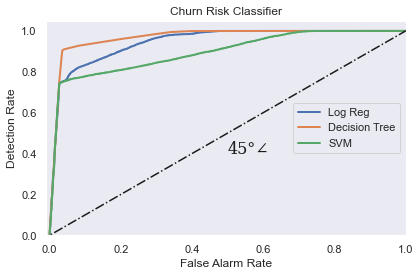

In [753]:
font = {'family': 'serif',
        'color':  'k',
        'weight': 'normal',
        'size': 16
        }

fpr_lr, tpr_lr, thr_lr = metrics.roc_curve(df_churn[idxtest][churn_target_col],
                                  df_churn[idxtest]['probability_lr'])
fpr_dt, tpr_dt, thr_dt = metrics.roc_curve(df_churn[idxtest][churn_target_col],
                                  df_churn[idxtest]['probability_dt'])
fpr_svm, tpr_svm, thr_svm = metrics.roc_curve(df_churn[idxtest][churn_target_col],
                                  df_churn[idxtest]['probability_svm'])

plt.plot(fpr_lr, tpr_lr, '-', lw=2, label='Log Reg')
plt.plot(fpr_dt, tpr_dt, '-', lw=2, label='Decision Tree')
plt.plot(fpr_svm, tpr_svm, '-', lw=2, label='SVM')
plt.plot([-.2,1.2], [-.2,1.2], linestyle='-.', color='k')
plt.text(0.5, 0.4, r'45°∠', fontdict=font)

plt.legend(loc='right')
plt.title('Churn Risk Classifier')
plt.grid()
plt.xlabel('False Alarm Rate')
plt.ylabel('Detection Rate')
plt.xlim((-0.01, 1))
plt.ylim((0.0, 1.05))
plt.show()

<font size="6"><div align="center"><span style="color:blue">Section VI - Comparing Classification Models - Validation Train x Validation Test</span></div></font>

<font size="3"><div align="left"><span style="color:black"> In that last Section VI the scores ( accuracy, F1, Precision and Recall ) of the classification models in the train validation x test validation were compared to understand the performance of each model. Is is possible to see that in all score the performance as similar</span></div></font>

In [754]:
print('Accuracy\n')
for v in nums(0,2):
    cc1 = vetor_x[v]
    cc2 = vetor_y[v]
    cc3 = vetor_yf[v]
    
    print(str(cc1)+' Train = ',cc2,str(cc1)+' Test = ',cc3,'\n')
    
print('F1 Score\n')
for v in nums(0,2):
    cc1 = vetor_x[v]
    cc2 = vetor_z[v]
    cc3 = vetor_zf[v]
    
    print(str(cc1)+' Train = ',cc2,str(cc1)+' Test = ',cc3,'\n')
    
print('Precision\n')
for v in nums(0,2):
    cc1 = vetor_x[v]
    cc2 = vetor_w[v]
    cc3 = vetor_wf[v]
    
    print(str(cc1)+' Train = ',cc2,str(cc1)+' Test = ',cc3,'\n')
    
print('Recall\n')
for v in nums(0,2):
    cc1 = vetor_x[v]
    cc2 = vetor_k[v]
    cc3 = vetor_kf[v]
    
    print(str(cc1)+' Train = ',cc2,str(cc1)+' Test = ',cc3,'\n')

Accuracy

Reg Log Train =  0.8710205566672731 Reg Log Test =  0.8650007796663028 

Decision Tree Train =  0.930325632162998 Decision Tree Test =  0.9324419148604397 

SVM Train =  0.7933418228124431 SVM Test =  0.7928816466552315 

F1 Score

Reg Log Train =  0.8723212677831802 Reg Log Test =  0.8674855546626871 

Decision Tree Train =  0.9332054412277643 Decision Tree Test =  0.9360540201468581 

SVM Train =  0.8113270220893538 SVM Test =  0.8119092292986865 

Precision

Reg Log Train =  0.9299289690919562 Reg Log Test =  0.9288699500122921 

Decision Tree Train =  0.9605097828038054 Decision Tree Test =  0.9630248272720371 

SVM Train =  0.7949552481692432 SVM Test =  0.8009359502689111 

Recall

Reg Log Train =  0.8214346277768356 Reg Log Test =  0.8137114142139268 

Decision Tree Train =  0.907410547736137 Decision Tree Test =  0.9105527638190954 

SVM Train =  0.8283873155841953 SVM Test =  0.8231873653984206 

